<a href="https://colab.research.google.com/github/cdiegor/MineracaoDeDados/blob/main/Pr%C3%A1tica_1_Introdu%C3%A7%C3%A3o_%C3%A0_Minera%C3%A7%C3%A3o_de_Dados_Fluxo_e_Valida%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Prática 1 - Fluxo de trabalho e validação de modelos

**Disciplina:** Introdução à Mineração de Dados  
**Foco da prática:** Entradas/saídas, ciclo de dados, particionamento (treino/validação/teste), métricas de avaliação, validação cruzada, curvas de aprendizado.



In [ ]:

# --- Preparação ------------------------------------------------------------------
# Se necessário, instale scikit-learn (em muitos ambientes educacionais já está instalado).
# !pip install scikit-learn pandas numpy matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer, fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,
    RocCurveDisplay, PrecisionRecallDisplay,
    mean_squared_error, r2_score, brier_score_loss
)
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.utils import shuffle

np.random.seed(7)



## 1. Fluxo de ML & divisões de dados

**Etapas típicas**: formulação do problema → coleta/limpeza/EDA → engenharia de atributos → modelagem → avaliação & validação → seleção → implantação/monitoramento.

**Divisões**:
- **Treino**: ajustar modelos e fazer tuning de hiperparâmetros (com CV no conjunto de treino).
- **Validação**: (opcional quando não se usa CV) seleção preliminar de modelos; em CV aninhada, o laço interno decide.
- **Teste**: uso **único** ao final, para estimativa imparcial.

> **Regra de ouro**: Nunca usar o conjunto de teste para tomar decisões de modelo/atributos.



## 2. Demonstração de classificação — Baseline, métricas e validação cruzada

Usaremos o conjunto **Breast Cancer Wisconsin** (classificação binária).


In [ ]:

# Carregar dados
data = load_breast_cancer(as_frame=True)
X = data.data
y = pd.Series(data.target, name="alvo")
X.head()


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:

# Split treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(X_train.shape, X_test.shape)
y_train.value_counts(normalize=True).round(3)


(455, 30) (114, 30)


,proportion
alvo,
1,0.626
0,0.374


In [ ]:

# Modelo baseline: Regressão Logística com padronização
pipe_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=200))
])

# Validação cruzada no conjunto de treino
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipe_lr, X_train, y_train, cv=cv, scoring="roc_auc")
print("CV ROC-AUC:", np.round(cv_scores, 4), "Média:", cv_scores.mean().round(4))


CV ROC-AUC: [0.9861 0.999  0.9969 0.999  0.9985] Média: 0.9959


In [ ]:

# Ajustar e avaliar no conjunto de teste
pipe_lr.fit(X_train, y_train)
proba = pipe_lr.predict_proba(X_test)[:, 1]
pred = (proba >= 0.5).astype(int)

acc = accuracy_score(y_test, pred)
prec = precision_score(y_test, pred)
rec = recall_score(y_test, pred)
f1 = f1_score(y_test, pred)
auc = roc_auc_score(y_test, proba)

print(f"Teste -> Acurácia={acc:.3f}  Precisão={prec:.3f}  Revocação={rec:.3f}  F1={f1:.3f}  ROC-AUC={auc:.3f}")


Teste -> Acurácia=0.982  Precisão=0.986  Revocação=0.986  F1=0.986  ROC-AUC=0.995


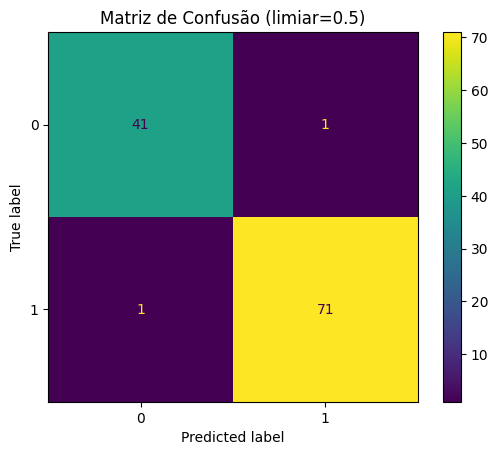

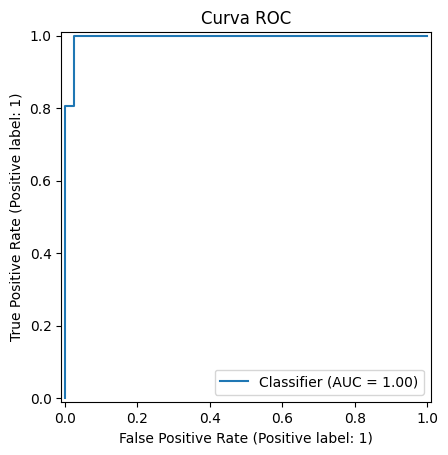

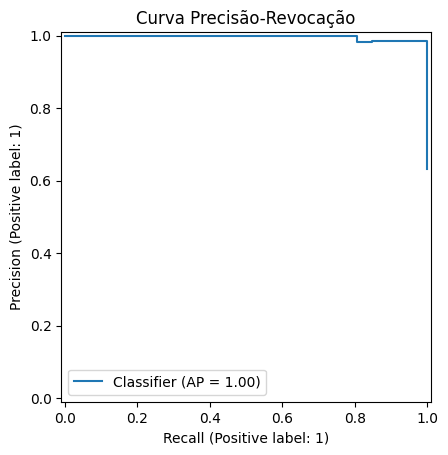

In [ ]:

# Matriz de confusão e curvas ROC/PR
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Matriz de Confusão (limiar=0.5)")
plt.show()

RocCurveDisplay.from_predictions(y_test, proba)
plt.title("Curva ROC")
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, proba)
plt.title("Curva Precisão-Revocação")
plt.show()



## 3. Curvas de aprendizado & intuição viés–variância

Curvas de aprendizado mostram o desempenho de treino e de validação em função do tamanho do conjunto de treino.


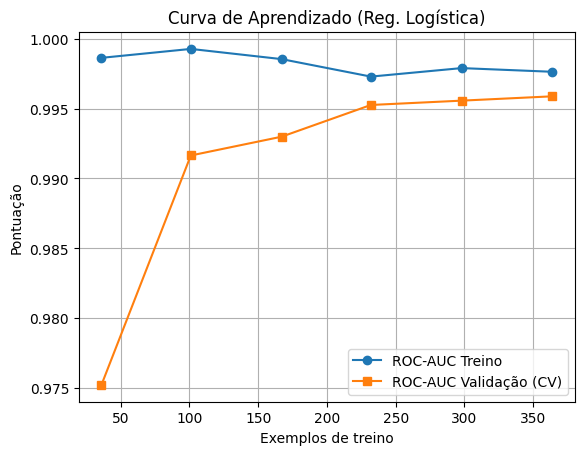

In [ ]:

train_sizes, train_scores, valid_scores = learning_curve(
    pipe_lr, X_train, y_train, cv=cv, scoring="roc_auc", train_sizes=np.linspace(0.1, 1.0, 6), n_jobs=None
)

train_mean = train_scores.mean(axis=1)
valid_mean = valid_scores.mean(axis=1)

plt.figure()
plt.plot(train_sizes, train_mean, marker='o', label="ROC-AUC Treino")
plt.plot(train_sizes, valid_mean, marker='s', label="ROC-AUC Validação (CV)")
plt.xlabel("Exemplos de treino")
plt.ylabel("Pontuação")
plt.title("Curva de Aprendizado (Reg. Logística)")
plt.legend()
plt.grid(True)
plt.show()



## 4. Calibração de probabilidades

Boas probabilidades são úteis (ajuste de limiares, decisões custo-sensíveis). Vamos inspecionar o **gráfico de calibração** e o **Brier score**.


Brier score = 0.0215 (menor é melhor)


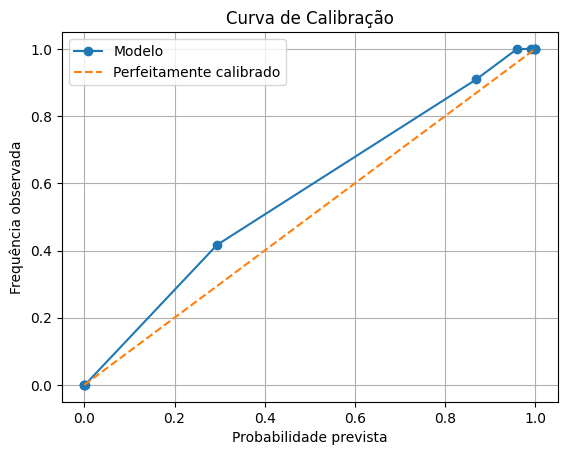

In [ ]:

prob_true, prob_pred = calibration_curve(y_test, proba, n_bins=10, strategy="quantile")
brier = brier_score_loss(y_test, proba)
print(f"Brier score = {brier:.4f} (menor é melhor)")

plt.figure()
plt.plot(prob_pred, prob_true, marker='o', label="Modelo")
plt.plot([0,1], [0,1], linestyle='--', label="Perfeitamente calibrado")
plt.xlabel("Probabilidade prevista")
plt.ylabel("Frequência observada")
plt.title("Curva de Calibração")
plt.legend()
plt.grid(True)
plt.show()



## 5. Desbalanceamento de classes & limiares

Desbalanceamento afeta as métricas. Vamos simular um desbalanceamento mais forte reduzindo a classe positiva no treino e comparar.


In [ ]:

# Treino desbalanceado (apenas para demonstração)
X_tr_imb, y_tr_imb = X_train.copy(), y_train.copy()
pos_idx = y_tr_imb[y_tr_imb == 1].index
keep_pos = np.random.choice(pos_idx, size=max(10, len(pos_idx)//5), replace=False)
mask = y_tr_imb.index.isin(keep_pos) | (y_tr_imb == 0)
X_tr_imb = X_tr_imb.loc[mask]
y_tr_imb = y_tr_imb.loc[mask]

pipe_lr_imb = Pipeline([("scaler", StandardScaler()), ("clf", LogisticRegression(max_iter=200, class_weight=None))])
pipe_lr_imb.fit(X_tr_imb, y_tr_imb)
proba_imb = pipe_lr_imb.predict_proba(X_test)[:, 1]

print("AUC do modelo padrão:", roc_auc_score(y_test, proba))
print("AUC do modelo treinado desbalanceado:", roc_auc_score(y_test, proba_imb))


AUC do modelo padrão: 0.9953703703703703
AUC do modelo treinado desbalanceado: 0.9950396825396824


In [ ]:

# Exemplo de ajuste de limiar no modelo padrão
thresholds = np.linspace(0.1, 0.9, 9)
records = []
for thr in thresholds:
    pred_thr = (proba >= thr).astype(int)
    records.append({
        "limiar": thr,
        "precisao": precision_score(y_test, pred_thr),
        "revocacao": recall_score(y_test, pred_thr),
        "f1": f1_score(y_test, pred_thr)
    })

thr_df = pd.DataFrame(records)
thr_df


,limiar,precisao,revocacao,f1
0,0.1,0.935065,1.000000,0.966443
1,0.2,0.972973,1.000000,0.986301
2,0.3,0.972973,1.000000,0.986301
3,0.4,0.986111,0.986111,0.986111
4,0.5,0.986111,0.986111,0.986111
5,0.6,0.985507,0.944444,0.964539
6,0.7,0.985294,0.930556,0.957143
7,0.8,0.985075,0.916667,0.949640
8,0.9,0.983871,0.847222,0.910448



## 6. Mini-demo de regressão — Métricas e validação

Usaremos **California Housing** para ilustrar métricas de regressão e validação.


In [ ]:

house = fetch_california_housing(as_frame=True)
Xr = house.data
yr = house.target

Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, yr, test_size=0.2, random_state=42)

pipe_lin = Pipeline([("scaler", StandardScaler(with_mean=False)), ("reg", LinearRegression())])
# with_mean=False evita problemas caso matrizes esparsas sejam usadas (aqui é denso).

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_mse = -cross_val_score(pipe_lin, Xr_train, yr_train, cv=kfold, scoring="neg_mean_squared_error")
print("CV RMSE:", np.sqrt(cv_mse).round(3), "Média:", np.sqrt(cv_mse.mean()).round(3))

pipe_lin.fit(Xr_train, yr_train)
pred_r = pipe_lin.predict(Xr_test)
rmse = np.sqrt(mean_squared_error(yr_test, pred_r))
r2 = r2_score(yr_test, pred_r)
print(f"Teste -> RMSE={rmse:.3f}  R2={r2:.3f}")


CV RMSE: [0.734 0.725 0.697 0.733 0.713] Média: 0.721
Teste -> RMSE=0.746  R2=0.576


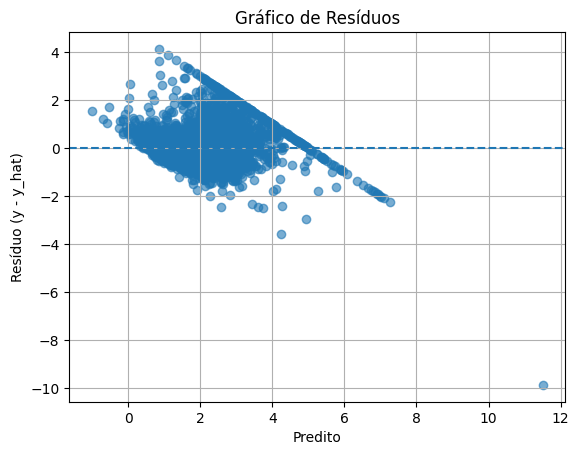

In [ ]:

# Gráfico de resíduos
resid = yr_test - pred_r
plt.figure()
plt.scatter(pred_r, resid, alpha=0.6)
plt.axhline(0, linestyle='--')
plt.xlabel("Predito")
plt.ylabel("Resíduo (y - y_hat)")
plt.title("Gráfico de Resíduos")
plt.grid(True)
plt.show()



## 7. Um fluxo mínimo de análise de erros

1) Escolha uma métrica-alvo clara.  
2) Fatie o desempenho por coortes relevantes (ex.: tamanho, região, tempo).  
3) Inspecione exemplos de alto erro (FP/FN).  
4) Hipotetize atributos/transformações úteis; rode pequenas modificações.  
5) Documente o que funcionou e o que não funcionou (reprodutibilidade).


# Exercícios

1. Do pacote ```sklearn.datasets``` utilize a função ```load_diabetes()``` para carregar os dados sobre diabetes disponíveis no scikit learn. Faça uma breve apresentação dos dados e indique qual problema o conjunto de dados se refere.

2. Utilize a função ```train_test_split``` para dividir o conjunto de dados em treino e teste com 20% dos exemplos destinado para o teste. Quantas instâncias ficaram para o treino? Qual a proporção de cada classe?

3. Crie um modelo para resolver o problema com um algoritmo de sua escolha. Faça a etapa de treino com a função ```fit```

4. Avalie o conjunto de teste gerado no exercício 2 e apresente a matriz de confusão obtida. Escolha uma métrica para avaliar o modelo. Justifique.

5. Crie um modelo alternativo com outro método (KNN, Regressão Logística, Árvore de decisão, etc.) e compare a matriz de confusão e a métrica obtida com a métrica do novo modelo.